**Les importations necessaires**

In [2]:
import kagglehub
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**chargement et exploration du dataset**

In [3]:
path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/best-alzheimer-mri-dataset-99-accuracy


In [6]:
combined_path = os.path.join(path, "Combined Dataset")
print(os.path.basename(combined_path))

# Parcourir train et test
for split in ["train", "test"]:
    split_path = os.path.join(combined_path, split)
    if not os.path.exists(split_path):
        continue

    print(f"{split}")
    classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        n_imgs = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png'))])
        print(f"{cls:20s} : {n_imgs} images")

Combined Dataset
train
No Impairment        : 2560 images
Very Mild Impairment : 2560 images
Moderate Impairment  : 2560 images
Mild Impairment      : 2560 images
test
No Impairment        : 640 images
Very Mild Impairment : 448 images
Moderate Impairment  : 12 images
Mild Impairment      : 179 images


**Préparation des données**

In [7]:
X = []
y = []
image_size = 150
categories = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']

def preprocess_image(image):
    image = cv2.resize(image, (image_size, image_size))
    image = image / 255.0  
    return image     

for split in ['train', 'test']:
    for label in categories:
        folderPath = f'/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/{split}/{label}'
        for filename in os.listdir(folderPath):
            img_path = os.path.join(folderPath, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = preprocess_image(img)
                X.append(img)
                y.append(categories.index(label))

X = np.array(X, dtype=np.float32)
y = np.array(y)

In [8]:
# Mélanger et diviser le dataset
X, y = shuffle(X, y, random_state=101)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# Conversion des labels en one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(categories))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(categories))

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

**Création du modèle**

In [10]:
# Définition du modèle ResNet50 avec couches CNN supplémentaires
base_model = ResNet50(
    weights=None, 
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

x = base_model.output

# Ajout de nouvelles couches CNN
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout pour éviter l'overfitting

outputs = Dense(len(categories), activation='softmax')(x)

# Création du modèle
model = Model(inputs=base_model.input, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 28,671,236 (109.37 MB)

 Trainable params: 28,617,348 (109.17 MB)

 Non-trainable params: 53,888 (210.50 KB)

**Compilation, Callbaks et Entrainement**

In [12]:
# Compilation du modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Définition des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=1e-4)

# Entraînement du modèle avec augmentation de données
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


I0000 00:00:1762987634.008290     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


324/324 ━━━━━━━━━━━━━━━━━━━━ 145s 280ms/step - accuracy: 0.3065 - loss: 1.5051 - val_accuracy: 0.2821 - val_loss: 1.6241 - learning_rate: 1.0000e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 63s 194ms/step - accuracy: 0.3459 - loss: 1.3128 - val_accuracy: 0.2821 - val_loss: 1.7987 - learning_rate: 1.0000e-04
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - accuracy: 0.4372 - loss: 1.1810 - val_accuracy: 0.2083 - val_loss: 8.7380 - learning_rate: 1.0000e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - accuracy: 0.5646 - loss: 0.9632 - val_accuracy: 0.4887 - val_loss: 1.1005 - learning_rate: 1.0000e-04
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/step - accuracy: 0.6027 - loss: 0.8672 - val_accuracy: 0.5642 - val_loss: 0.9995 - learning_rate: 1.0000e-04
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - accuracy: 0.6395 - loss: 0.7815 - val_accuracy: 0.6111 - val_loss: 0.8728 - learning_rate: 1.0000e-04
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/

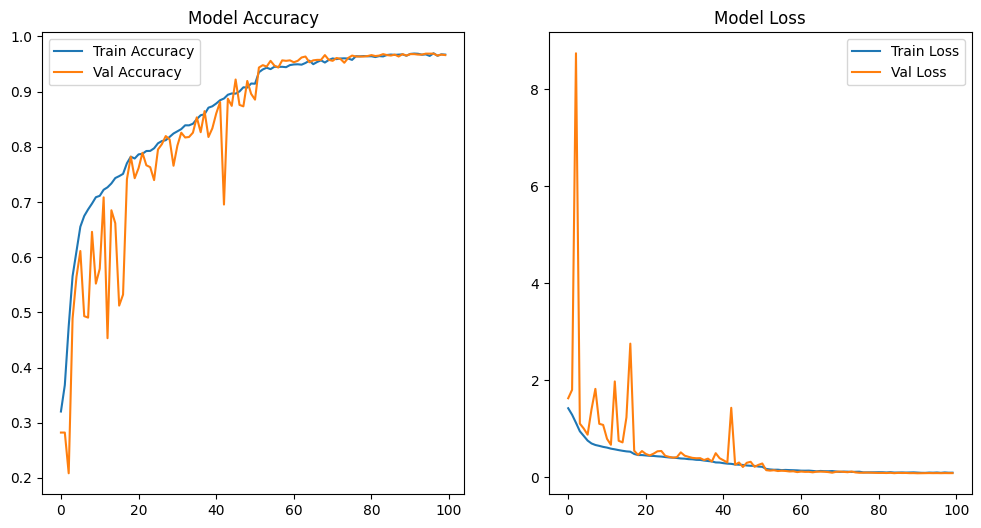

In [13]:
# Plot accuracy and loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

**Matrice de confusion**

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step
Classification Report:

                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.97      0.98       284
 Moderate Impairment       1.00      1.00      1.00       240
       No Impairment       0.96      0.96      0.96       325
Very Mild Impairment       0.94      0.95      0.94       303

            accuracy                           0.97      1152
           macro avg       0.97      0.97      0.97      1152
        weighted avg       0.97      0.97      0.97      1152



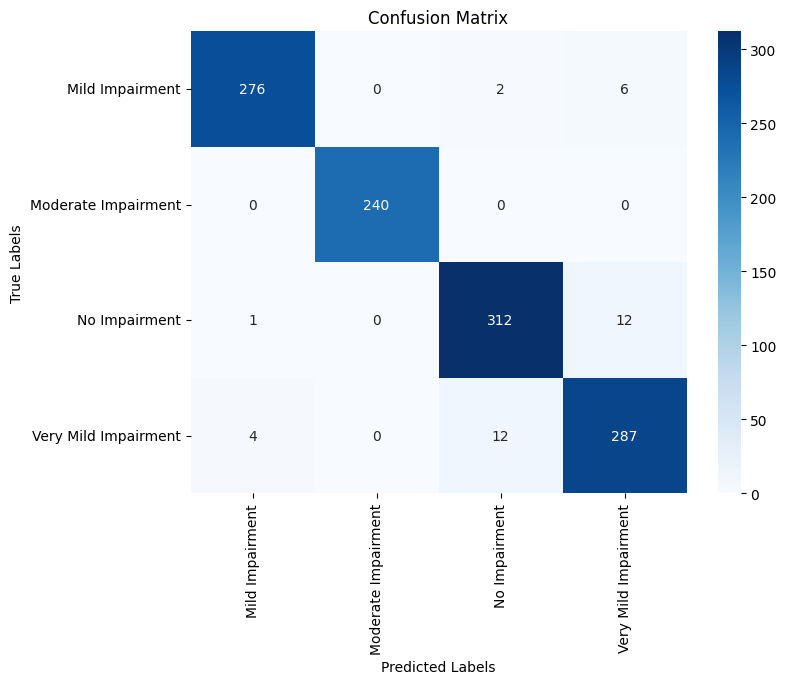

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir en labels de classe
y_true = np.argmax(y_test, axis=1)  # Labels réels

# Affichage du rapport de classification
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=categories))

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

**Evaluation**

In [15]:
train_accuracy = history.history['accuracy'][-1]  
val_accuracy = history.history['val_accuracy'][-1] 

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Affichage des résultats
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 96.70%
Validation Accuracy: 96.61%
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9671 - loss: 0.0832
Test Loss: 0.0769
Test Accuracy: 96.79%


**Prédictions sur le jeu de test**

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


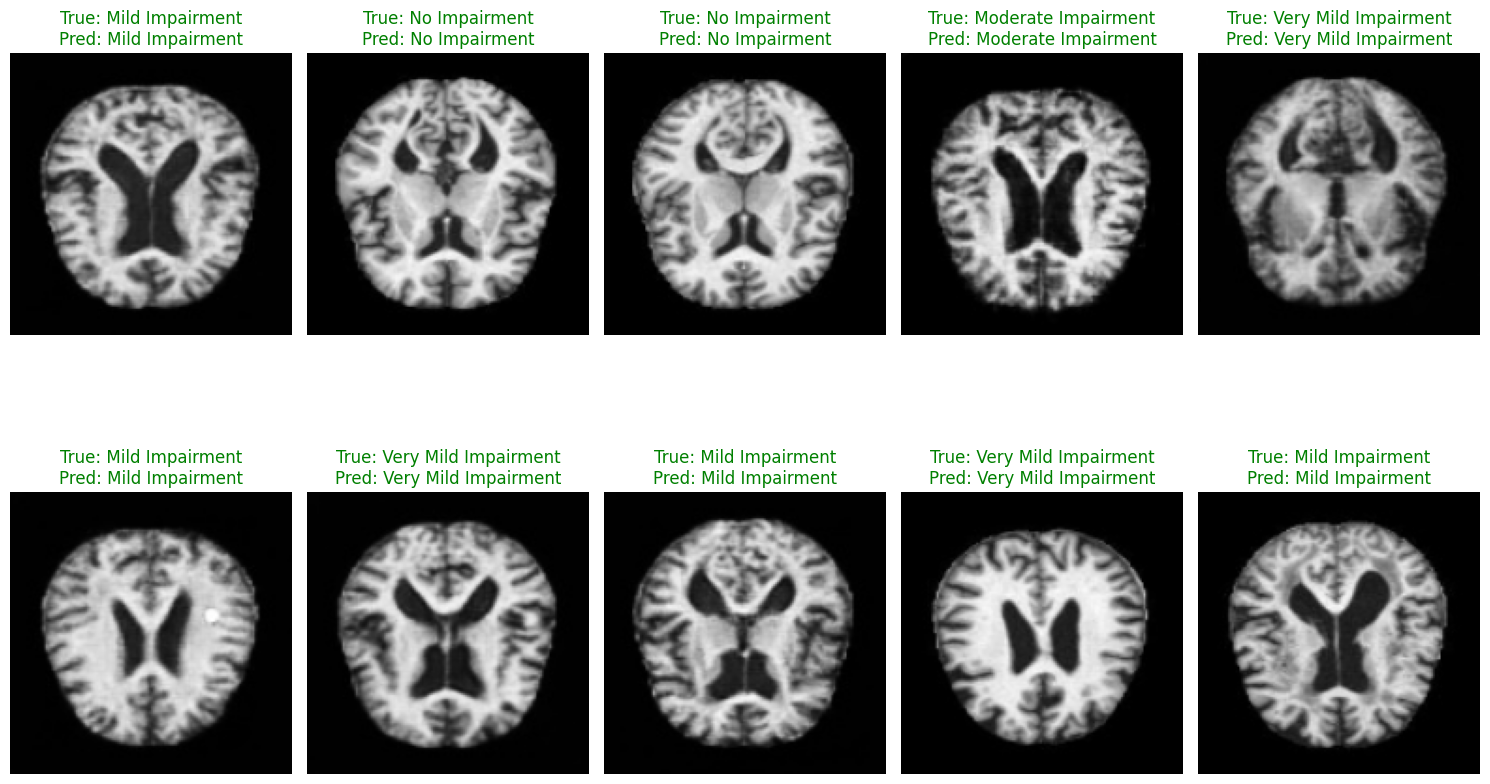

In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true_classes = np.argmax(y_test, axis=1)  

num_images = 10
plt.figure(figsize=(15, 10))

for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i])
    plt.axis('off')
    true_label = categories[y_true_classes[i]]
    predicted_label = categories[y_pred_classes[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color='green' if true_label == predicted_label else 'red')

plt.tight_layout()
plt.show()